### EVODEX Single-Reaction Pipeline Demonstration

This notebook runs the EVODEX algorithms to mine operators for a single input reaction. This is for debugging and demonstration purposes only.  Though the pipeline that was used to make EVODEX.0 uses the same chemoinformatic algorithms as this, there is additional bookkeeping and error handling in the batch process performed by running run_pipeline.py.

In [1]:
# Installation of the EVODEX library and import of evaluation methods
!pip install evodex -q
from collections import defaultdict
from evodex.decofactor import remove_cofactors
from evodex.operators import extract_operator
from evodex.formula import calculate_formula_diff, calculate_exact_mass
from evodex.splitting import split_reaction
from evodex.utils import reaction_hash
from evodex.astatine import hydrogen_to_astatine_reaction
from evodex.mapping import map_atoms

from rdkit import Chem
from rdkit.Chem import Draw

# Additional imports used in this notebook
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import rdMolDraw2D


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 18.5 MB/s eta 0:00:00


In [2]:
# Install Indigo toolkit for cheminformatics
!pip install epam.indigo -q

# Import and initialize Indigo and its components
from indigo import Indigo
indigo = Indigo()
from indigo.renderer import IndigoRenderer
renderer = IndigoRenderer(indigo)

import os
import uuid
from IPython.display import Image, display

def render_reaction_smirks(reaction_smirks: str) -> None:
    try:
        # Load reaction SMIRKS
        reaction = indigo.loadReactionSmarts(reaction_smirks)

        # Set rendering options
        indigo.setOption("render-output-format", "png")
        indigo.setOption("render-implicit-hydrogens-visible", False)
        indigo.setOption("embedding-uniqueness", "none")
        indigo.setOption("render-bond-length", 40)
        indigo.setOption("render-atom-ids-visible", True)  # Show atom mapping numbers

        reaction.aromatize()
        reaction.correctReactingCenters()

        # Generate unique file path
        file_path = f"{uuid.uuid4()}.png"

        # Render to file
        renderer.renderToFile(reaction, file_path)

        # Display the image
        print(f"Displaying image from: {file_path}")
        display(Image(filename=file_path))

    except Exception as e:
        print(f"Error rendering reaction image: {e}")

# Example usage
# reaction_smirks = "C(C(=O)[O:4][C:5]([#1:10])([#1:11])[#1:12])([#1])([#1])[#1]>>[#1][O:4][C:5]([#1:10])([#1:11])[#1:12]"
# render_reaction_smirks(reaction_smirks)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 30.7 MB/s eta 0:00:00


## Block 1: Input the reaction

Displaying image from: 9e743169-f9a8-4550-9b87-84db8f3fa6c6.png


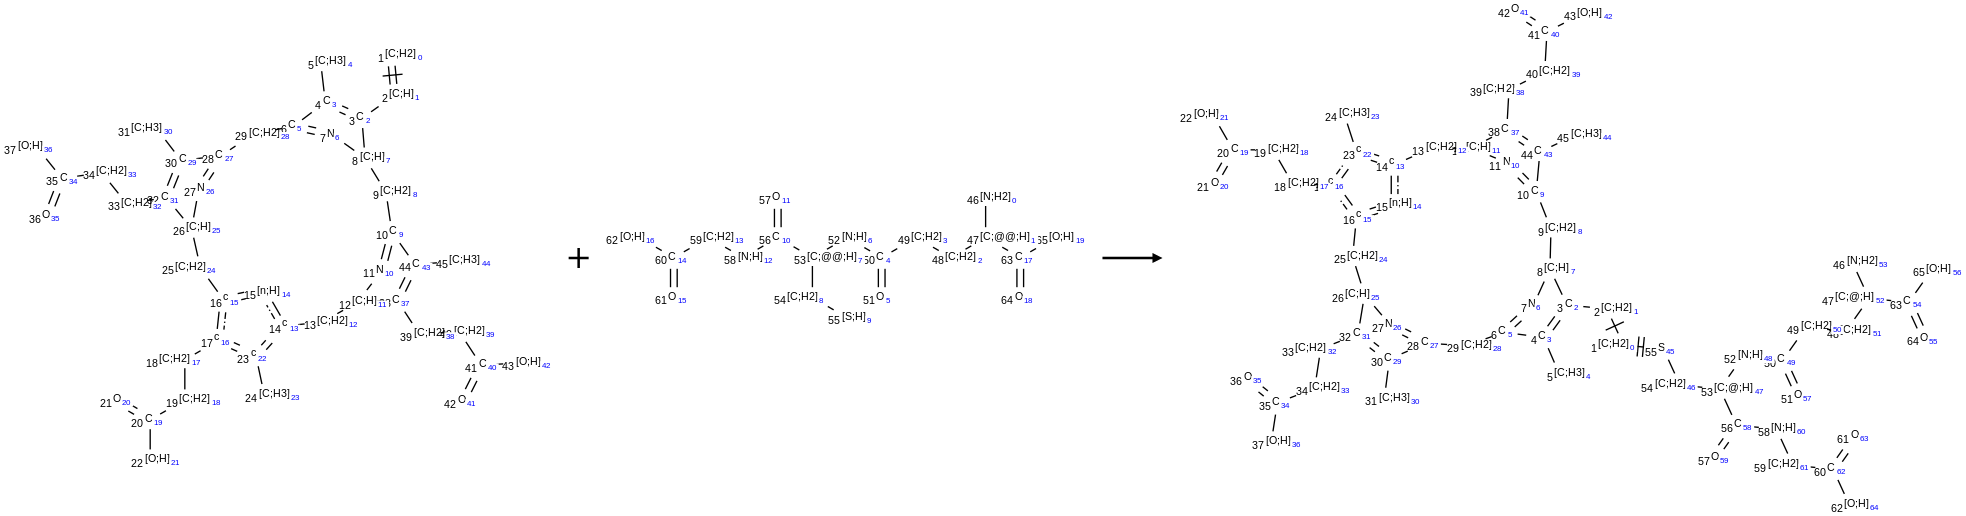

In [3]:
# GST reaction harderoporphyrinogen + glutathione = harderoporphyrinogen-S-glutathione + H2O
smirks = '[CH2:1]=[CH:2][C:3]1=[C:4]([CH3:5])[C:6]2=[N:7][CH:8]1[CH2:9][C:10]1=[N:11][CH:12]([CH2:13][c:14]3[nH:15][c:16]([c:17]([CH2:18][CH2:19][C:20](=[O:21])[OH:22])[c:23]3[CH3:24])[CH2:25][CH:26]3[N:27]=[C:28]([CH2:29]2)[C:30]([CH3:31])=[C:32]3[CH2:33][CH2:34][C:35](=[O:36])[OH:37])[C:38]([CH2:39][CH2:40][C:41](=[O:42])[OH:43])=[C:44]1[CH3:45].[NH2:46][C@@H:47]([CH2:48][CH2:49][C:50](=[O:51])[NH:52][C@@H:53]([CH2:54][SH:55])[C:56](=[O:57])[NH:58][CH2:59][C:60](=[O:61])[OH:62])[C:63](=[O:64])[OH:65]>>[CH2:1]([CH2:2][C:3]1=[C:4]([CH3:5])[C:6]2=[N:7][CH:8]1[CH2:9][C:10]1=[N:11][CH:12]([CH2:13][c:14]3[nH:15][c:16]([c:17]([CH2:18][CH2:19][C:20](=[O:21])[OH:22])[c:23]3[CH3:24])[CH2:25][CH:26]3[N:27]=[C:28]([CH2:29]2)[C:30]([CH3:31])=[C:32]3[CH2:33][CH2:34][C:35](=[O:36])[OH:37])[C:38]([CH2:39][CH2:40][C:41](=[O:42])[OH:43])=[C:44]1[CH3:45])[S:55][CH2:54][C@H:53]([NH:52][C:50]([CH2:49][CH2:48][C@H:47]([NH2:46])[C:63](=[O:64])[OH:65])=[O:51])[C:56](=[O:57])[NH:58][CH2:59][C:60](=[O:61])[OH:62]'
render_reaction_smirks(smirks)

## Block 2: Initial Reaction Processing
Process the initial reaction to convert all hydrogens to astatine. This is done to avoid any ambiguity or error caused by implicit/explicit hydrogens. The astatines are subsquently atom mapped.

Original Reaction SMIRKS:
Displaying image from: d340d9f9-bb8a-4d64-be81-10e18a640ff0.png


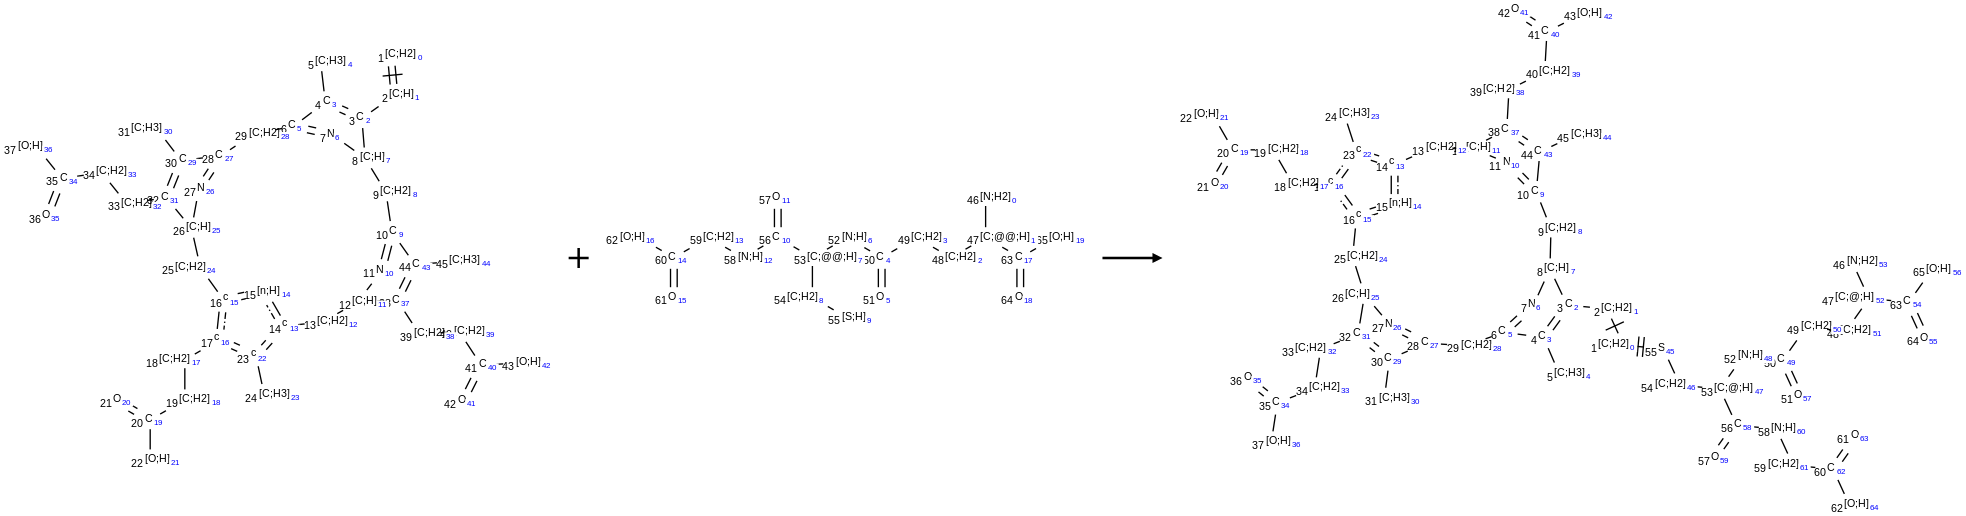

Astatine SMIRKS:
Displaying image from: 7b259e11-93c5-4631-bb9a-5ea22e6b19fc.png


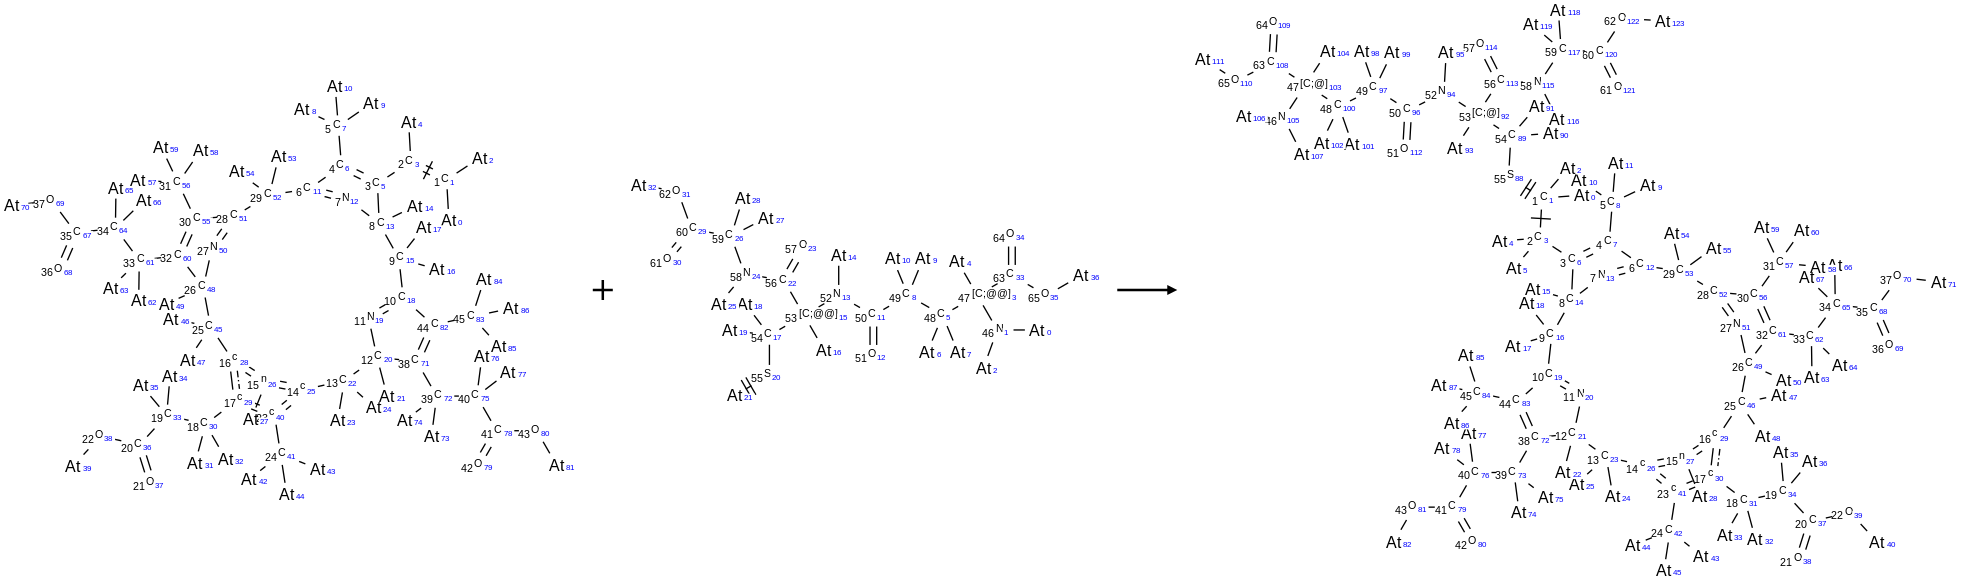

Mapped SMIRKS:
Displaying image from: 307dcb6c-60e1-4d5f-9ac0-f869e6c5fe94.png


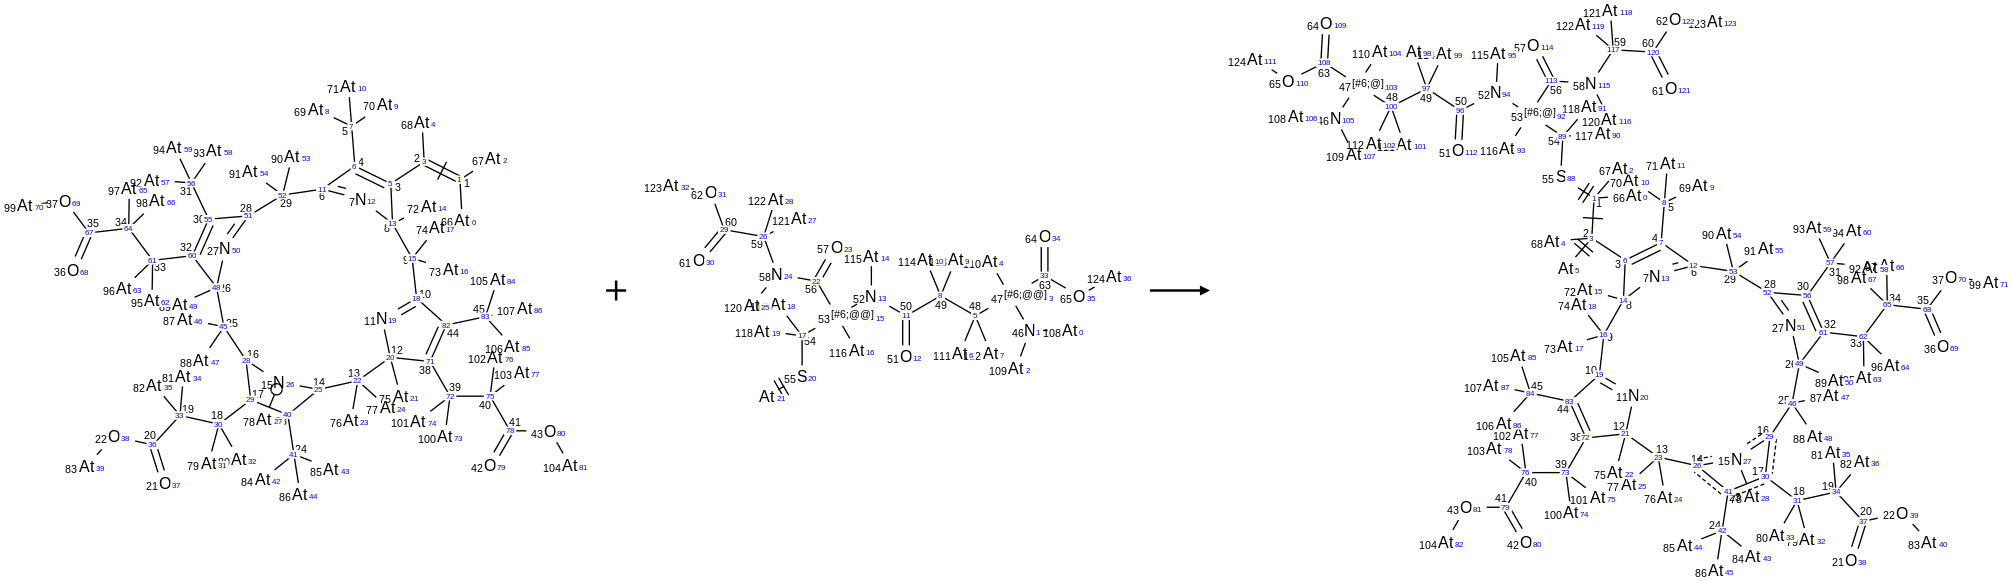

In [4]:
# Block 2: Initial Reaction Processing

# Display the original reaction
print("Original Reaction SMIRKS:")
render_reaction_smirks(smirks)

# Convert to astatine
astatine_smirks = hydrogen_to_astatine_reaction(smirks)
print("Astatine SMIRKS:")
render_reaction_smirks(astatine_smirks)

# Map atoms
mapped_smirks = map_atoms(astatine_smirks)
print("Mapped SMIRKS:")
render_reaction_smirks(mapped_smirks)


# Block 3: Split Reactions to EVODEX-P

EVODEX-P Partial Reactions:
Partial Reaction 0:
Displaying image from: 7ba774f8-c804-4246-820f-779b20e08cd9.png


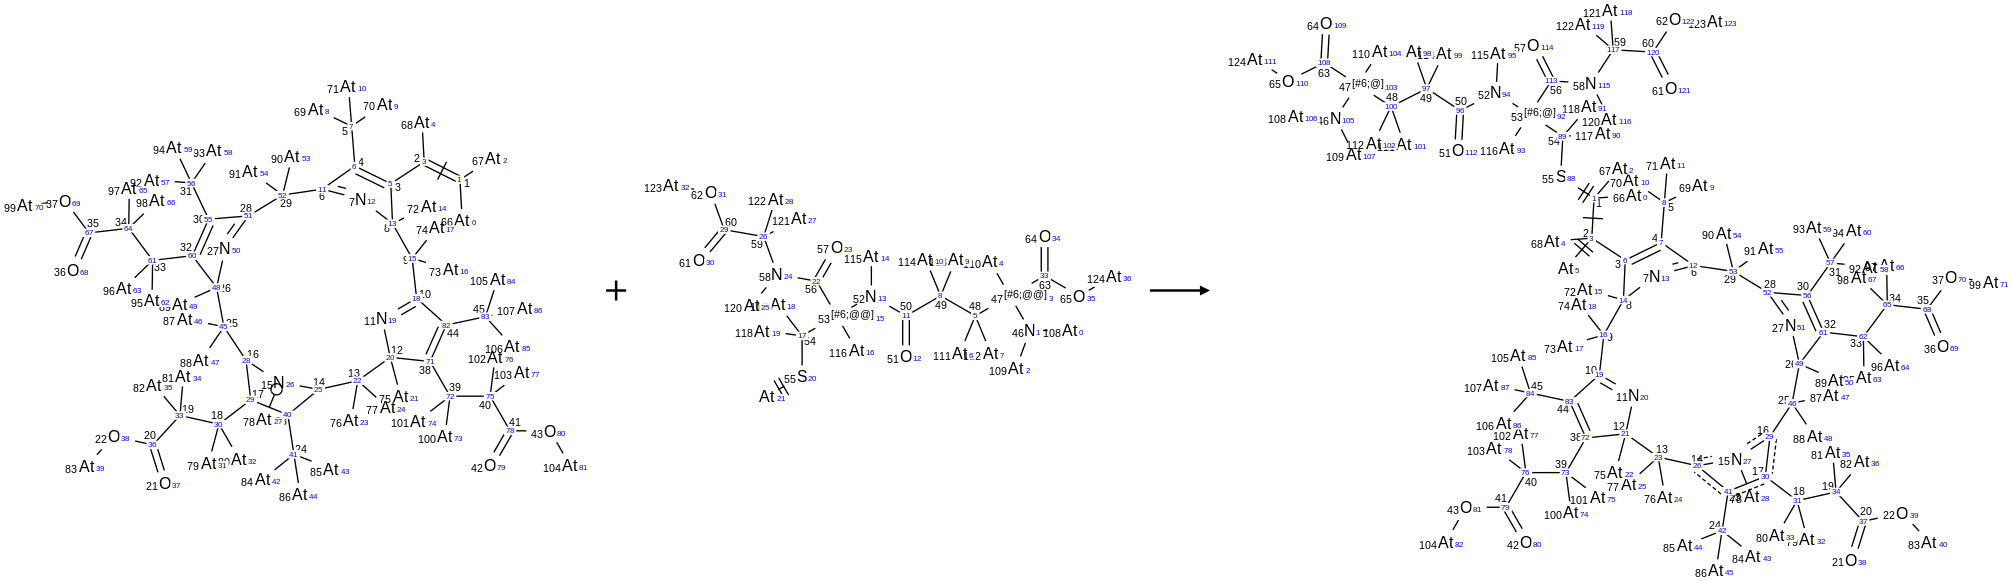

[At:66]-[#6:1](-[At:67])=[#6:2](-[At:68])-[#6:3]1=[#6:4](-[#6:5](-[At:69])(-[At:70])-[At:71])-[#6:6]2=[#7:7]-[#6:8]-1(-[At:72])-[#6:9](-[At:73])(-[At:74])-[#6:10]1=[#7:11]-[#6:12](-[At:75])(-[#6:13](-[At:76])(-[At:77])-[#6:14]3:[#7:15](-[At:78]):[#6:16](:[#6:17](-[#6:18](-[At:79])(-[At:80])-[#6:19](-[At:81])(-[At:82])-[#6:20](=[#8:21])-[#8:22]-[At:83]):[#6:23]:3-[#6:24](-[At:84])(-[At:85])-[At:86])-[#6:25](-[At:87])(-[At:88])-[#6:26]3(-[At:89])-[#7:27]=[#6:28](-[#6:29]-2(-[At:90])-[At:91])-[#6:30](-[#6:31](-[At:92])(-[At:93])-[At:94])=[#6:32]-3-[#6:33](-[At:95])(-[At:96])-[#6:34](-[At:97])(-[At:98])-[#6:35](=[#8:36])-[#8:37]-[At:99])-[#6:38](-[#6:39](-[At:100])(-[At:101])-[#6:40](-[At:102])(-[At:103])-[#6:41](=[#8:42])-[#8:43]-[At:104])=[#6:44]-1-[#6:45](-[At:105])(-[At:106])-[At:107].[At:108]-[#7:46](-[At:109])-[#6@@:47](-[At:110])(-[#6:48](-[At:111])(-[At:112])-[#6:49](-[At:113])(-[At:114])-[#6:50](=[#8:51])-[#7:52](-[At:115])-[#6@@:53](-[At:116])(-[#6:54](-[At:117])(-[At:118])-[#16:

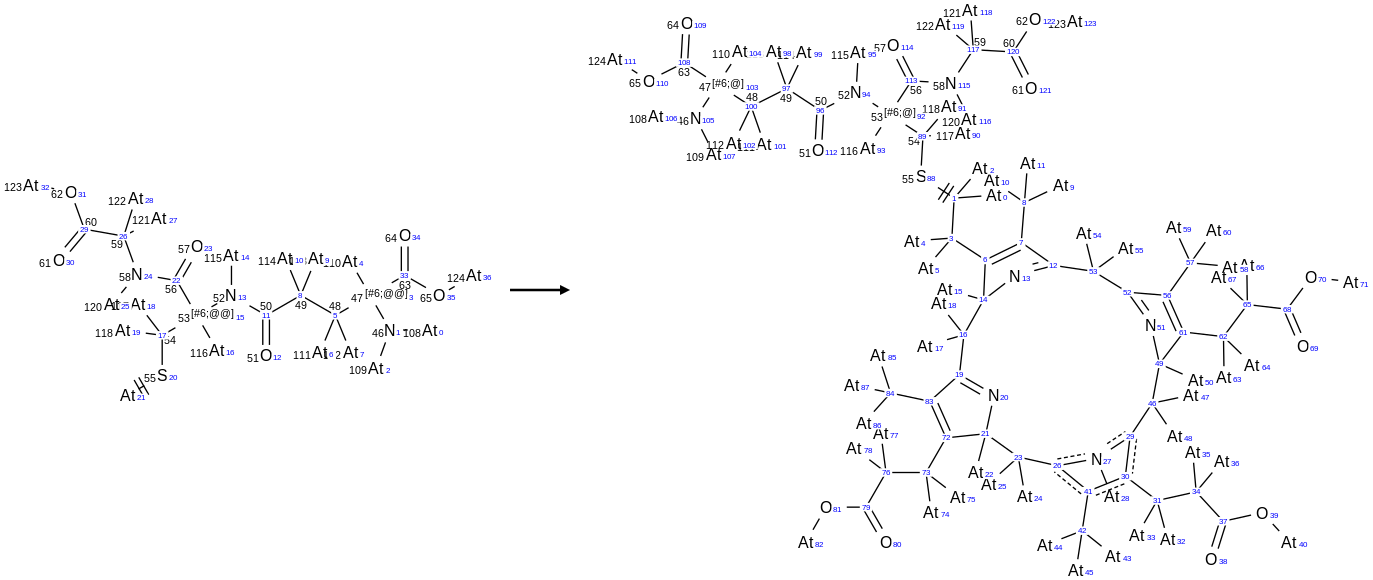

[At:108]-[#7:46](-[At:109])-[#6@@:47](-[At:110])(-[#6:48](-[At:111])(-[At:112])-[#6:49](-[At:113])(-[At:114])-[#6:50](=[#8:51])-[#7:52](-[At:115])-[#6@@:53](-[At:116])(-[#6:54](-[At:117])(-[At:118])-[#16:55]-[At])-[#6:56](=[#8:57])-[#7:58](-[At:120])-[#6:59](-[At:121])(-[At:122])-[#6:60](=[#8:61])-[#8:62]-[At:123])-[#6:63](=[#8:64])-[#8:65]-[At:124]>>[At]-[#6](-[At])(-[#6](-[At])(-[At])-[#6]1=[#6](-[#6](-[At])(-[At])-[At])-[#6]2=[#7]-[#6]-1(-[At])-[#6](-[At])(-[At])-[#6]1=[#7]-[#6](-[At])(-[#6](-[At])(-[At])-[#6]3:[#7](-[At]):[#6](:[#6](-[#6](-[At])(-[At])-[#6](-[At])(-[At])-[#6](=[#8])-[#8]-[At]):[#6]:3-[#6](-[At])(-[At])-[At])-[#6](-[At])(-[At])-[#6]3(-[At])-[#7]=[#6](-[#6]-2(-[At])-[At])-[#6](-[#6](-[At])(-[At])-[At])=[#6]-3-[#6](-[At])(-[At])-[#6](-[At])(-[At])-[#6](=[#8])-[#8]-[At])-[#6](-[#6](-[At])(-[At])-[#6](-[At])(-[At])-[#6](=[#8])-[#8]-[At])=[#6]-1-[#6](-[At])(-[At])-[At])-[#16:55]-[#6:54](-[At:117])(-[At:118])-[#6@:53](-[At:116])(-[#7:52](-[At:115])-[#6:50](-[#6:49](-[At:1

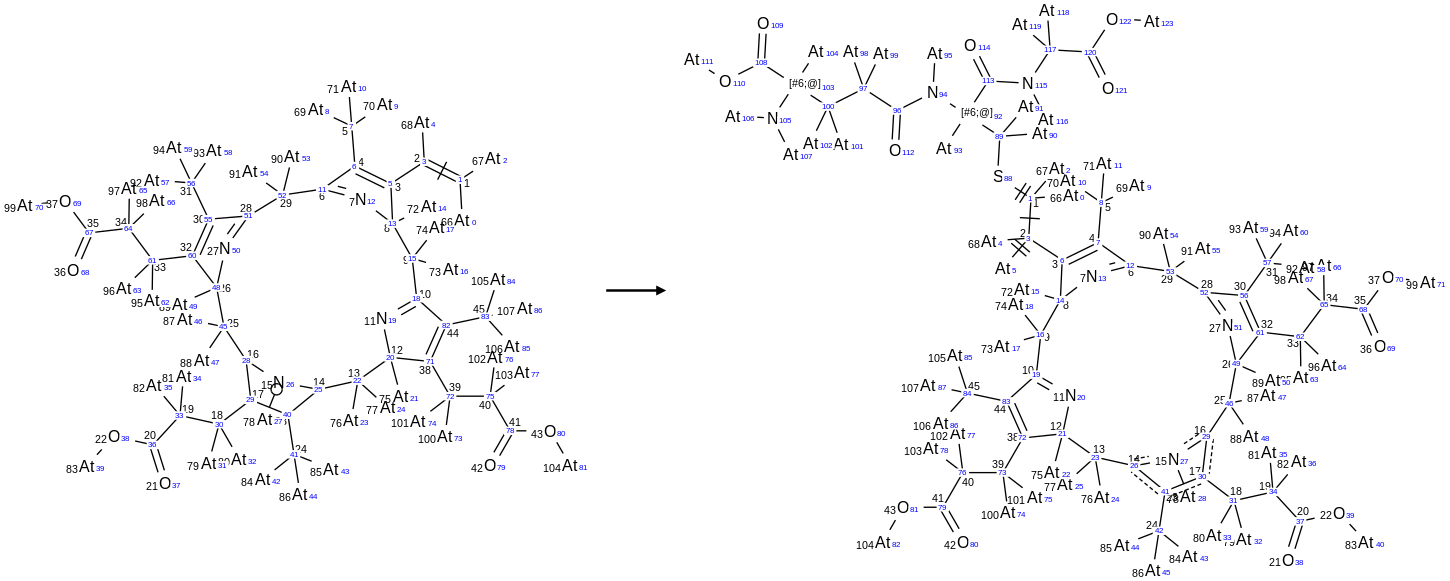

[At:66]-[#6:1](-[At:67])=[#6:2](-[At:68])-[#6:3]1=[#6:4](-[#6:5](-[At:69])(-[At:70])-[At:71])-[#6:6]2=[#7:7]-[#6:8]-1(-[At:72])-[#6:9](-[At:73])(-[At:74])-[#6:10]1=[#7:11]-[#6:12](-[At:75])(-[#6:13](-[At:76])(-[At:77])-[#6:14]3:[#7:15](-[At:78]):[#6:16](:[#6:17](-[#6:18](-[At:79])(-[At:80])-[#6:19](-[At:81])(-[At:82])-[#6:20](=[#8:21])-[#8:22]-[At:83]):[#6:23]:3-[#6:24](-[At:84])(-[At:85])-[At:86])-[#6:25](-[At:87])(-[At:88])-[#6:26]3(-[At:89])-[#7:27]=[#6:28](-[#6:29]-2(-[At:90])-[At:91])-[#6:30](-[#6:31](-[At:92])(-[At:93])-[At:94])=[#6:32]-3-[#6:33](-[At:95])(-[At:96])-[#6:34](-[At:97])(-[At:98])-[#6:35](=[#8:36])-[#8:37]-[At:99])-[#6:38](-[#6:39](-[At:100])(-[At:101])-[#6:40](-[At:102])(-[At:103])-[#6:41](=[#8:42])-[#8:43]-[At:104])=[#6:44]-1-[#6:45](-[At:105])(-[At:106])-[At:107]>>[At:66]-[#6:1](-[At:67])(-[#6:2](-[At:68])(-[At])-[#6:3]1=[#6:4](-[#6:5](-[At:69])(-[At:70])-[At:71])-[#6:6]2=[#7:7]-[#6:8]-1(-[At:72])-[#6:9](-[At:73])(-[At:74])-[#6:10]1=[#7:11]-[#6:12](-[At:75])(-[#6:

In [5]:
split_reactions = split_reaction(mapped_smirks)

print("EVODEX-P Partial Reactions:")
for i, reaction in enumerate(split_reactions):
    print(f"Partial Reaction {i}:")
    render_reaction_smirks(reaction)
    print(reaction)

# Block 4: Select EVODEX-P and Generate EVODEX-F, -M, Cm, Nm, Em, C, N, E

Selected EVODEX-P Reaction: [At:66]-[#6:1](-[At:67])=[#6:2](-[At:68])-[#6:3]1=[#6:4](-[#6:5](-[At:69])(-[At:70])-[At:71])-[#6:6]2=[#7:7]-[#6:8]-1(-[At:72])-[#6:9](-[At:73])(-[At:74])-[#6:10]1=[#7:11]-[#6:12](-[At:75])(-[#6:13](-[At:76])(-[At:77])-[#6:14]3:[#7:15](-[At:78]):[#6:16](:[#6:17](-[#6:18](-[At:79])(-[At:80])-[#6:19](-[At:81])(-[At:82])-[#6:20](=[#8:21])-[#8:22]-[At:83]):[#6:23]:3-[#6:24](-[At:84])(-[At:85])-[At:86])-[#6:25](-[At:87])(-[At:88])-[#6:26]3(-[At:89])-[#7:27]=[#6:28](-[#6:29]-2(-[At:90])-[At:91])-[#6:30](-[#6:31](-[At:92])(-[At:93])-[At:94])=[#6:32]-3-[#6:33](-[At:95])(-[At:96])-[#6:34](-[At:97])(-[At:98])-[#6:35](=[#8:36])-[#8:37]-[At:99])-[#6:38](-[#6:39](-[At:100])(-[At:101])-[#6:40](-[At:102])(-[At:103])-[#6:41](=[#8:42])-[#8:43]-[At:104])=[#6:44]-1-[#6:45](-[At:105])(-[At:106])-[At:107]>>[At:66]-[#6:1](-[At:67])(-[#6:2](-[At:68])(-[At])-[#6:3]1=[#6:4](-[#6:5](-[At:69])(-[At:70])-[At:71])-[#6:6]2=[#7:7]-[#6:8]-1(-[At:72])-[#6:9](-[At:73])(-[At:74])-[#6:10]1=[#7

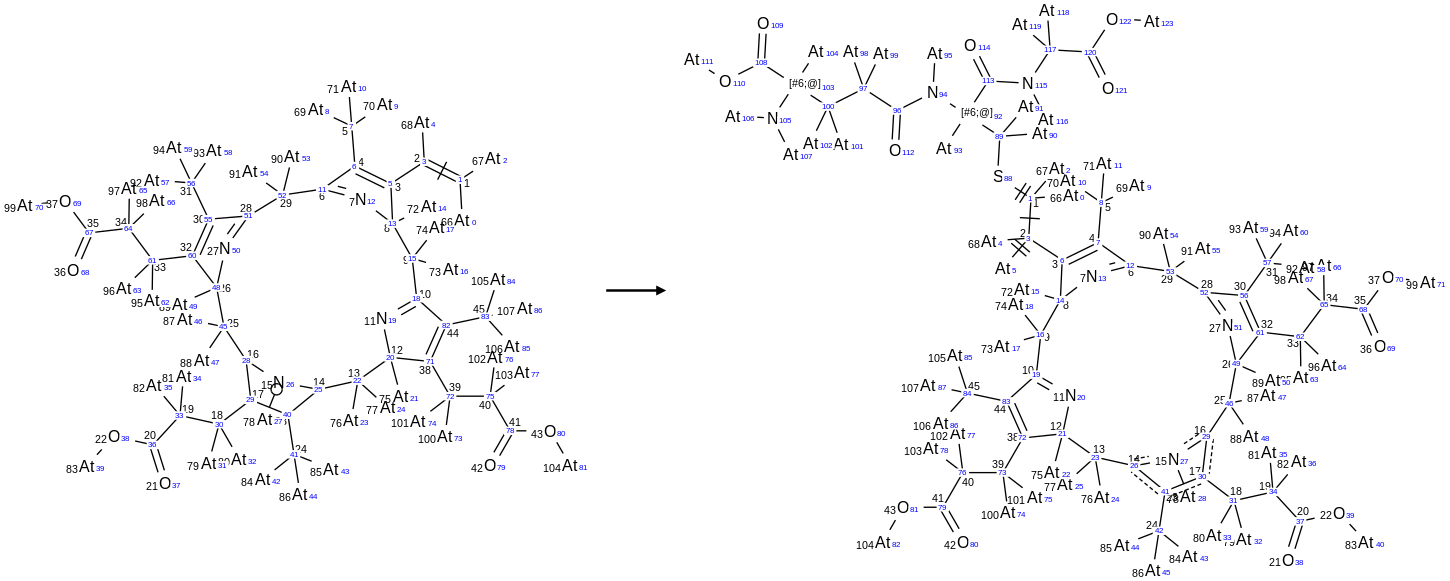

EVODEX-F: {'O': 6, 'C': 10, 'N': 3, 'S': 1, 'H': 17}
EVODEX-M Mass Difference: 307.08391
EVODEX-Cm: [#6:1]=[#6:2]>>[#6:1](-[#6:2]-[#85])-[#16]
Displaying image from: 135322a1-9311-42c0-9bc0-51b6caebd688.png


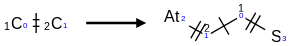

EVODEX-Nm: [#6:1]=[#6:2]-[#6:3]>>[#6:1](-[#6:2](-[#85])-[#6:3])-[#16]-[#6]
Displaying image from: b4867ce3-7511-4eb1-b607-859e23cb319c.png


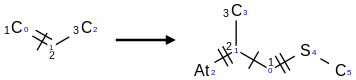

EVODEX-Em: [#6:1]=[#6:2]-[#6:3]=[#6:4]-[#6:6]=[#7:7]>>[#6:1](-[#6:2](-[#85])-[#6:3]=[#6:4]-[#6:6]=[#7:7])-[#16]-[#6]
Displaying image from: b86d3a7b-bbea-438f-a20d-4cf5e612a825.png


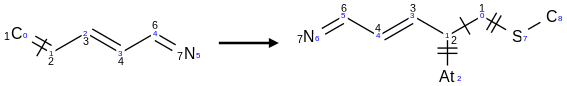

EVODEX-C: [#6:1]=[#6:2]>>[#6:1](-[#6:2]-[#85])-[#16]-[#6](-[#85])(-[#85])-[#6@](-[#85])(-[#7](-[#85])-[#6](-[#6](-[#85])(-[#85])-[#6](-[#85])(-[#85])-[#6@](-[#85])(-[#7](-[#85])-[#85])-[#6](=[#8])-[#8]-[#85])=[#8])-[#6](=[#8])-[#7](-[#85])-[#6](-[#85])(-[#85])-[#6](=[#8])-[#8]-[#85]
Displaying image from: 30c61d22-9665-4791-9b0b-747c09ea2081.png


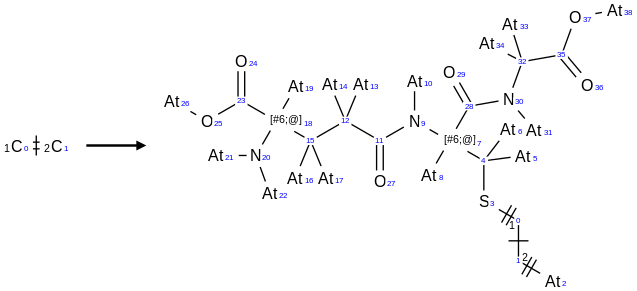

EVODEX-N: [#85:66]-[#6:1](-[#85:67])=[#6:2](-[#85:68])-[#6:3]>>[#85:66]-[#6:1](-[#85:67])(-[#6:2](-[#85:68])(-[#85])-[#6:3])-[#16]-[#6](-[#85])(-[#85])-[#6@](-[#85])(-[#7](-[#85])-[#6](-[#6](-[#85])(-[#85])-[#6](-[#85])(-[#85])-[#6@](-[#85])(-[#7](-[#85])-[#85])-[#6](=[#8])-[#8]-[#85])=[#8])-[#6](=[#8])-[#7](-[#85])-[#6](-[#85])(-[#85])-[#6](=[#8])-[#8]-[#85]
Displaying image from: 0849811d-76c8-40ef-8d7f-9d3d21e72fd7.png


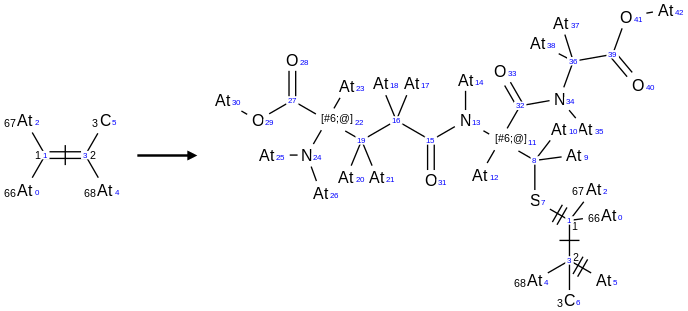

EVODEX-E: [#85:66]-[#6:1](-[#85:67])=[#6:2](-[#85:68])-[#6:3]=[#6:4]-[#6:6]=[#7:7]>>[#85:66]-[#6:1](-[#85:67])(-[#6:2](-[#85:68])(-[#85])-[#6:3]=[#6:4]-[#6:6]=[#7:7])-[#16]-[#6](-[#85])(-[#85])-[#6@](-[#85])(-[#7](-[#85])-[#6](-[#6](-[#85])(-[#85])-[#6](-[#85])(-[#85])-[#6@](-[#85])(-[#7](-[#85])-[#85])-[#6](=[#8])-[#8]-[#85])=[#8])-[#6](=[#8])-[#7](-[#85])-[#6](-[#85])(-[#85])-[#6](=[#8])-[#8]-[#85]
Displaying image from: ed78b1b5-9671-4adc-ac77-d67b1c0b9d9a.png


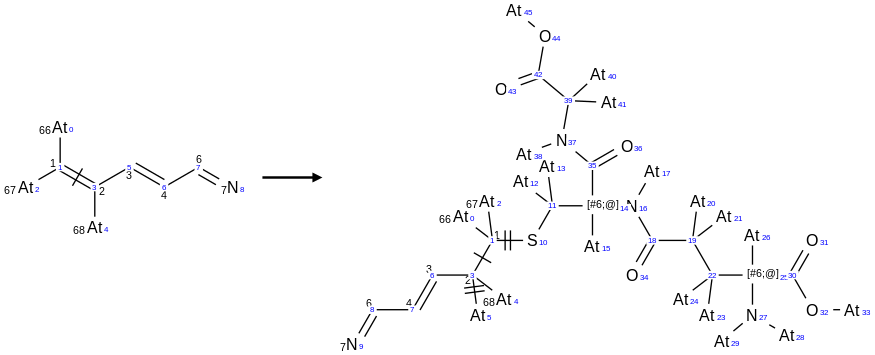

In [6]:

# Select the index of the EVODEX-P reaction to proceed with
selected_index = 2
selected_p_reaction = split_reactions[selected_index]

print(f"Selected EVODEX-P Reaction: {selected_p_reaction}")
render_reaction_smirks(selected_p_reaction)

# EVODEX-F
formula_diff = calculate_formula_diff(selected_p_reaction)
evodex_f_smirks = str(formula_diff)
print(f"EVODEX-F: {evodex_f_smirks}")

# EVODEX-M
mass_diff = calculate_exact_mass(formula_diff)
print(f"EVODEX-M Mass Difference: {mass_diff}")

# EVODEX-Cm
params_cm = {
    'include_stereochemistry': False,
    'include_sigma': False,
    'include_pi': False,
    'include_unmapped_hydrogens': False,
    'include_unmapped_heavy_atoms': False,
    'include_static_hydrogens': False
}
evodex_cm_smirks = extract_operator(selected_p_reaction, **params_cm)
print(f"EVODEX-Cm: {evodex_cm_smirks}")
render_reaction_smirks(evodex_cm_smirks)

# EVODEX-Nm
params_nm = {
    'include_stereochemistry': False,
    'include_sigma': True,
    'include_pi': False,
    'include_unmapped_hydrogens': False,
    'include_unmapped_heavy_atoms': False,
    'include_static_hydrogens': False
}
evodex_nm_smirks = extract_operator(selected_p_reaction, **params_nm)
print(f"EVODEX-Nm: {evodex_nm_smirks}")
render_reaction_smirks(evodex_nm_smirks)

# EVODEX-Em
params_em = {
    'include_stereochemistry': False,
    'include_sigma': True,
    'include_pi': True,
    'include_unmapped_hydrogens': False,
    'include_unmapped_heavy_atoms': False,
    'include_static_hydrogens': False
}
evodex_em_smirks = extract_operator(selected_p_reaction, **params_em)
print(f"EVODEX-Em: {evodex_em_smirks}")
render_reaction_smirks(evodex_em_smirks)

# EVODEX-C
params_c = {
    'include_stereochemistry': True,
    'include_sigma': False,
    'include_pi': False,
    'include_unmapped_hydrogens': True,
    'include_unmapped_heavy_atoms': True,
    'include_static_hydrogens': True
}
evodex_c_smirks = extract_operator(selected_p_reaction, **params_c)
print(f"EVODEX-C: {evodex_c_smirks}")
render_reaction_smirks(evodex_c_smirks)

# EVODEX-N
params_n = {
    'include_stereochemistry': True,
    'include_sigma': True,
    'include_pi': False,
    'include_unmapped_hydrogens': True,
    'include_unmapped_heavy_atoms': True,
    'include_static_hydrogens': True
}
evodex_n_smirks = extract_operator(selected_p_reaction, **params_n)
print(f"EVODEX-N: {evodex_n_smirks}")
render_reaction_smirks(evodex_n_smirks)

# EVODEX-E
params_e = {
    'include_stereochemistry': True,
    'include_sigma': True,
    'include_pi': True,
    'include_unmapped_hydrogens': True,
    'include_unmapped_heavy_atoms': True,
    'include_static_hydrogens': True
}
evodex_e_smirks = extract_operator(selected_p_reaction, **params_e)
print(f"EVODEX-E: {evodex_e_smirks}")
render_reaction_smirks(evodex_e_smirks)
